In [1]:
import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
import cv2 as cv
import warnings as warn
import skimage.measure as meas
from keras import backend as K, preprocessing, \
                  models, layers, optimizers, \
                  utils, callbacks, initializers, \
                  activations, regularizers, applications, \
                  constraints, engine
from numpy import linalg as la, random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection
from sklearn import preprocessing as spre
from tqdm import tnrange, tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from jupyterthemes import jtplot

D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ten

In [2]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
class StopOnValue(callbacks.Callback):
    def __init__(self, 
                 monitor='val_loss', 
                 value=0.00001, 
                 mode='min',
                 verbose=0):
        super(callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.mode = mode
        if self.mode == 'min':
            self.compare_op = np.less
        elif self.mode == 'max':
            self.compare_op = np.greater
    
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' % self.monitor, 
                          RuntimeWarning)
            
        if self.compare_op(current, self.value):
            if self.verbose > 0:
                print('Epoch %05d: early stopping THR' % epoch)
            self.model.stop_training = True
            
            
class AdaBound(optimizers.Optimizer):
    def __init__(self,
                 lr=0.001,
                 final_lr=0.1,
                 beta_1=0.9,
                 beta_2=0.999,
                 gamma=1e-3,
                 epsilon=None,
                 decay=0.,
                 amsbound=False,
                 weight_decay=0.,
                 **kwargs):
        """
        Keras port [1] of AdaBound Optimizer for PyTorch [2], from the paper 
        Adaptive Gradient Methods with Dynamic Bound of Learning Rate [3].
        
        AdaBound optimizer.
        
        Default parameters follow those provided in the original paper.
        # Arguments
            lr: float >= 0. Learning rate.
            final_lr: float >= 0. Final learning rate.
            beta_1: float, 0 < beta < 1. Generally close to 1.
            beta_2: float, 0 < beta < 1. Generally close to 1.
            gamma: float >= 0. Convergence speed of the bound function.
            epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
            decay: float >= 0. Learning rate decay over each update.
            weight_decay: Weight decay weight.
            amsbound: boolean. Whether to apply the AMSBound variant of this
                algorithm.
        
        [1] Majumdar, S. keras-adabound, 2019. https://github.com/titu1994/keras-adabound.
        [2] Luo, L. AdaBound, 2019. https://github.com/Luolc/AdaBound.
        [3] Luo, L., Yuanhao, X., Yan, L., and Xu, S. Adaptive gradient methods with dynamic
            bound of learning rate. International Conference on LEarning Representations, 2019.
            https://openreview.net/forum?id=Bkg3g2R9FX.
        """
        super(AdaBound, self).__init__(**kwargs)
        
        if not 0. < gamma <= 1.:
            raise ValueError('Invalid `gamma` parameter. Must lie in [0, 1] range.')
            
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            
        self.final_lr = final_lr
        self.gamma = gamma
        
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)
        
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

class SGDRScheduler(callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)
    
def l2loss(y_true, y_pred):
    return tf.nn.l2_loss(y_pred - y_true)

def shannonEntropy2D(img, base=2):       
    img_grad = np.asarray(np.gradient(img)).T
    img_grad /= img_grad.max()
    img_grad = np.uint8(img_grad * 255)
    hist = np.squeeze(cv.calcHist([img_grad], [0, 1], None, [256, 256], [0, 256, 0, 256]))
    hist /= img_grad.size
    with warn.catch_warnings():
        warn.simplefilter('ignore')
        if base == 2:
            log = np.log2
        elif base == 10:
            log = np.log10
        elif base == 'e':
            log = np.log
        H = -1/2 * np.nansum(hist*log(hist))
    return H

## Fruit classifier

In [15]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/fruits-360/Training/'

In [36]:
def abe_extractor(directories):
    alist, blist, elist = [], [], []
    for j in range(len(directories)):
        filenames = os.listdir(directories[j])
        for i,f in enumerate(filenames):
            img = cv.imread(directories[j] + f)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            thres, out = cv.threshold(img_gray, 127, 255, cv.THRESH_OTSU)
            out = (img_gray < thres).astype(float)
            with warn.catch_warnings():
                warn.simplefilter('ignore')
                img_label = meas.label(out)
                props = meas.regionprops(img_label)
                ecc = props[0]['eccentricity']

            img_Lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)/255
            img_L, img_a, img_b = cv.split(img_Lab)

            alist.append(img_a.mean())
            blist.append(img_b.mean())
            elist.append(ecc)

    class_a = np.asarray(alist)
    class_b = np.asarray(blist)
    class_e = np.asarray(elist)
    return class_a, class_b, class_e

In [37]:
appledirs = [traindir + 'Apple Red 1/',
             traindir + 'Apple Red 2/',
             traindir + 'Apple Red 3/',
             traindir + 'Apple Crimson Snow/',
             traindir + 'Apple Braeburn/']
app_a, app_b, app_e = abe_extractor(appledirs)

In [38]:
bananadirs = [traindir + 'Banana/',
              traindir + 'Banana Lady Finger/']
ban_a, ban_b, ban_e = abe_extractor(bananadirs)

In [39]:
orangedirs = [traindir + 'Orange/']
ora_a, ora_b, ora_e = abe_extractor(orangedirs)

In [40]:
cherrydirs = [traindir + 'Cherry 1/',
              traindir + 'Cherry Wax Black/']
che_a, che_b, che_e = abe_extractor(cherrydirs)

In [41]:
astars = [app_a, ban_a, ora_a, che_a]
bstars = [app_b, ban_b, ora_b, che_b]
class_border = np.cumsum([len(a) for a in astars])

In [42]:
X = np.column_stack((np.concatenate(astars), np.concatenate(bstars)))
y = np.zeros(len(X), 'uint8')
for i in range(1, len(class_border)):
    y[class_border[i-1]:class_border[i]] = i
y = utils.to_categorical(y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.5, 
                                                                    shuffle=True)

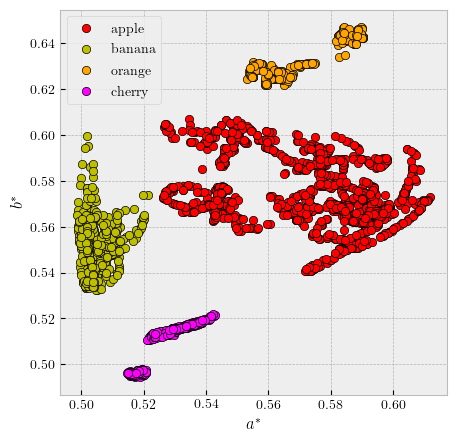

In [43]:
plt.plot(X_train[:,0][y_train.argmax(axis=1) == 0],
         X_train[:,1][y_train.argmax(axis=1) == 0],
         'ro', mew=0.5, mec='k', label='apple')
plt.plot(X_train[:,0][y_train.argmax(axis=1) == 1],
         X_train[:,1][y_train.argmax(axis=1) == 1],
         'yo', mew=0.5, mec='k', label='banana')
plt.plot(X_train[:,0][y_train.argmax(axis=1) == 2],
         X_train[:,1][y_train.argmax(axis=1) == 2],
         'o', color='orange', mew=0.5, mec='k', label='orange')
plt.plot(X_train[:,0][y_train.argmax(axis=1) == 3],
         X_train[:,1][y_train.argmax(axis=1) == 3],
         'o', color='magenta', mew=0.5, mec='k', label='cherry')
plt.legend()
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
# plt.savefig('fruits-train.png', dpi=300, bbox_inches='tight')
plt.show()

In [62]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(X_train.shape[1],),
                            name='input'))
model.add(layers.Dense(units=len(X_train),
                       name='hidden1',
                       activation='relu'))
model.add(layers.Dense(units=len(X_train)//10,
                       name='hidden2',
                       activation='relu'))
model.add(layers.Dense(units=len(X_train)//100,
                       name='hidden3',
                       activation='sigmoid'))
model.add(layers.Dense(units=len(class_border),
                       name='output',
                       activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 2376)              7128      
_________________________________________________________________
hidden2 (Dense)              (None, 237)               563349    
_________________________________________________________________
hidden3 (Dense)              (None, 23)                5474      
_________________________________________________________________
output (Dense)               (None, 4)                 96        
Total params: 576,047
Trainable params: 576,047
Non-trainable params: 0
_________________________________________________________________


In [63]:
stopval = StopOnValue(monitor='val_loss',
                      value=0.01,
                      mode='min')
estop = callbacks.EarlyStopping(monitor='val_mean_squared_error',
                                min_delta=1e-12,
                                patience=5,
                                mode='min',
                                baseline=0.1)
checkpoint = callbacks.ModelCheckpoint('fruit_best_weights.h5',
                                       monitor='val_loss',
                                       verbose=0,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='min')

In [65]:
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['acc', 'categorical_crossentropy'])

In [66]:
history = model.fit(X_train, y_train,
                    batch_size=len(X_train),
                    validation_split=0.2,
                    epochs=int(1e6),
                    verbose=0,
                    callbacks=[ktqdm(leave_inner=True), stopval, checkpoint])
model.save('fruits.model')

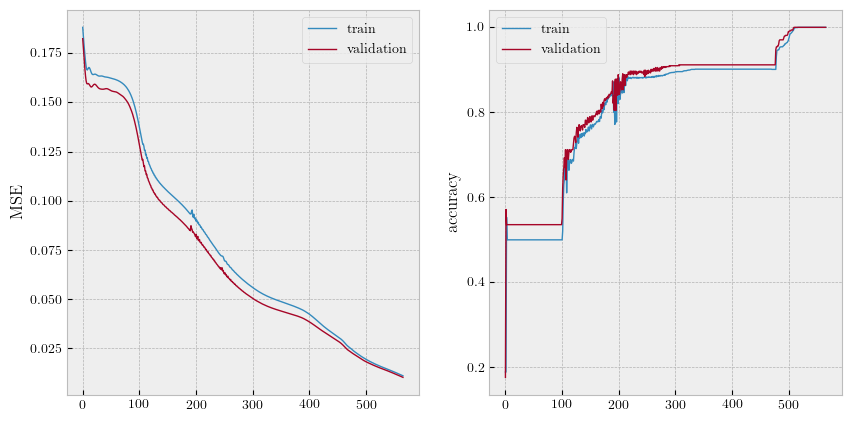

In [68]:
fig = plt.figure(figsize=(5*2, 5))

ax = fig.add_subplot(121)
ax.plot(history.epoch, history.history['loss'], lw=1)
ax.plot(history.epoch, history.history['val_loss'], lw=1)
ax.legend(['train', 'validation'])
ax.set_ylabel('MSE')

ax = fig.add_subplot(122)
ax.plot(history.epoch, history.history['acc'], lw=1)
ax.plot(history.epoch, history.history['val_acc'], lw=1)
ax.legend(['train', 'validation'])
ax.set_ylabel('accuracy')

# plt.savefig('multiple-curves.png', bbox_inches='tight', dpi=300)
plt.show()

In [70]:
preds = model.predict(X_test, batch_size=len(X_test))
print('Test accuracy:', 
      len(np.squeeze(np.where(abs(np.round(preds) - y_test).sum(axis=1) == 0)))/len(y_test) * 100)

Test accuracy: 99.95791245791246


In [71]:
xmin, xmax = np.min(np.concatenate(astars))-5e-3, np.max(np.concatenate(astars))+5e-3
ymin, ymax = np.min(np.concatenate(bstars))-5e-3, np.max(np.concatenate(bstars))+5e-3
xx, yy = np.linspace(xmin, xmax, 500), np.linspace(ymin, ymax, 500)
X, Y = np.meshgrid(xx, yy)
Z = np.c_[X.ravel(), Y.ravel()]
Z = model.predict(Z)
Z = Z.argmax(axis=1).reshape(X.shape)

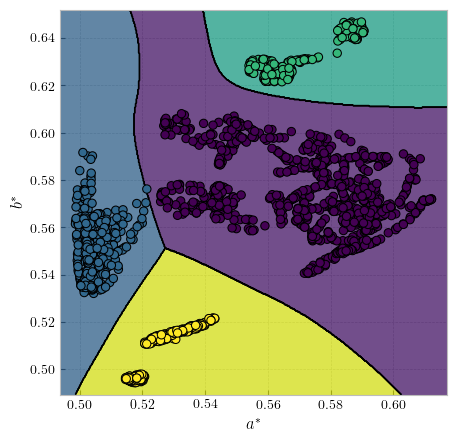

In [73]:
# for i,c,l in zip(range(3), ['y', 'orange', 'r'], ['banana', 'orange', 'apple']):
#     plt.plot(X_train[y_train.argmax(axis=1) == i][:,0]/255, 
#              X_train[y_train.argmax(axis=1) == i][:,1]/255,
#              'o', color=c, mew=0.75, mec='k', label=l)

plt.scatter(X_test[:,0], X_test[:,1], c=y_test.argmax(axis=1),
            linewidths=0.75, edgecolors='k', zorder=5, cmap='viridis')
plt.contourf(X, Y, Z, cmap='viridis', alpha=0.75)
plt.contour(X, Y, Z, linestyles='-', colors='k', linewidths=0.75)
# plt.legend()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
# plt.savefig('multiple-decision.png', bbox_inches='tight', dpi=300)
plt.show()

## Function fitter

In [ ]:
f = 1
X_train = rand.uniform(-1, 1, 500)
X_train = np.sort(X_train)
y_train = np.sin(2*np.pi*f*X_train)

X_train = np.expand_dims(X_train, 1)
y_train = np.expand_dims(y_train, 1)

X_test = np.expand_dims(np.linspace(-1, 1, 500), 1)

In [84]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(1,),
                            name='input'))
for i, u in enumerate([50]):
    model.add(layers.Dense(units=u,
                           kernel_initializer='random_uniform',
                           activation='relu',
                           name='hidden%s' %str(i+1)))
model.add(layers.Dense(units=1,
                       activation='linear',
                       name='output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 50)                100       
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [85]:
epochs = int(1e6)
batch_size = len(X_train)
stopval = StopOnValue(monitor='loss',
                      mode='min',
                      value=0.01)
lrred = callbacks.ReduceLROnPlateau(min_lr=1e-4,
                                    patience=10,
                                    factor=0.2,
                                    mode='min')
estop = callbacks.EarlyStopping(monitor='loss',
                                min_delta=1e-2,
                                patience=10,
                                verbose=0,
                                mode='min',
                                baseline=0.1)
sgdr = SGDRScheduler(min_lr=1e-4,
                     max_lr=1e-2,
                     steps_per_epoch=np.ceil(epochs/batch_size),
                     lr_decay=0.9,
                     cycle_length=5,
                     mult_factor=1.5)
checkpoint = callbacks.ModelCheckpoint('funcfit_best_weights.h5',
                                       monitor='loss',
                                       verbose=0,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='min')

In [86]:
model.compile(loss=l2loss,
              optimizer=AdaBound(lr=0.1,
                                 final_lr=1e-3,
                                 amsbound=True))

In [87]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[ktqdm(leave_inner=True), stopval, checkpoint])

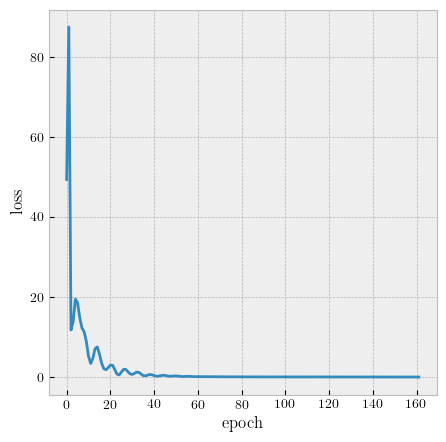

In [91]:
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.savefig('fit-2-loss.png', bbox_inches='tight', dpi=300)
plt.show()

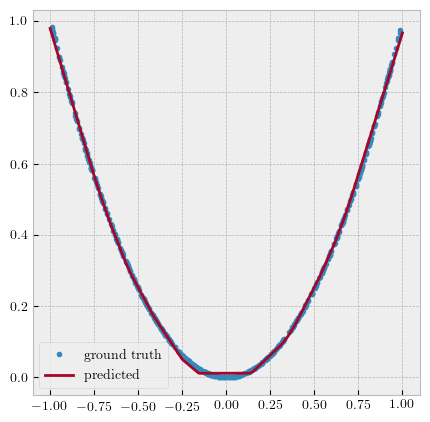

In [90]:
res = model.predict(X_test).squeeze()

plt.plot(X_train, y_train, '.', label='ground truth')
plt.plot(X_test, res, label='predicted')
plt.legend()
# plt.savefig('fit-2-pred.png', bbox_inches='tight', dpi=300)
plt.show()